# Analyzing "removal requests" data from Twitter's transparency reports

Note: Each report refers to a six-month period ending with the month in the `report` column. The data in the reports cover **just those six months** and do not represent cumulative counts.

## Step 1: Load the report data

In [1]:
import pandas as pd
import glob
import re
import seaborn
%matplotlib inline

In [2]:
def load_report(path):
    _, month_start, month_end, year = path.split("/")[-1][:-4].rsplit("-", 3)
    df = pd.read_csv(
        path,
        encoding="latin-1",
    )
    df["report"] = "{}-{:02d}".format(year, 6 if month_start == "jan" else 12)
    return df[
        ~df["COUNTRY"].isin(["TOTALS", "TOTAL", "", pd.np.nan])
    ].copy()

In [3]:
reports = pd.concat([ load_report(path)
    for path in glob.glob("../data/twitter-transparency-reports/removal-requests-report-*.csv") ])\
    .sort_values(["report", "ISO CODE"])\
    .reset_index(drop=True)

In [4]:
reports.head()

,ACCOUNTS (NO ACTION),ACCOUNTS (TOS),ACCOUNTS SPECIFIED,ACCOUNTS WITHHELD,COUNTRY,FLAGS,ISO CODE,LINKS,PERCENTAGE WHERE SOME CONTENT WITHHELD,REMOVAL REQUESTS (COURT ORDERS),"REMOVAL REQUESTS (GOVERNMENT AGENCY, POLICE, OTHER)","REMOVAL REQUESTS (GOVâT AGENCY, POLICE, OTHER)","REMOVAL REQUESTS (GOVäó»T AGENCY, POLICE, OTHER)",REPORT LINKS,TIME PERIOD,TWEETS WITHHELD,report
0,NaN,NaN,2,NaN,France,/content/dam/transparency-twitter/flags/1x1/fr...,FR,/en/countries/fr.html,0%,0,NaN,1,NaN,/en/removal-requests.html#removal-requests-jan...,January - June 2012,NaN,2012-06
1,NaN,NaN,6,NaN,United Kingdom,/content/dam/transparency-twitter/flags/1x1/gb...,GB,/en/countries/gb.html,0%,0,NaN,1,NaN,/en/removal-requests.html#removal-requests-jan...,January - June 2012,NaN,2012-06
2,NaN,NaN,2,NaN,Greece,/content/dam/transparency-twitter/flags/1x1/gr...,GR,/en/countries/gr.html,0%,2,NaN,0,NaN,/en/removal-requests.html#removal-requests-jan...,January - June 2012,NaN,2012-06
3,NaN,NaN,1,NaN,Pakistan,/content/dam/transparency-twitter/flags/1x1/pk...,PK,/en/countries/pk.html,0%,0,NaN,1,NaN,/en/removal-requests.html#removal-requests-jan...,January - June 2012,NaN,2012-06
4,NaN,NaN,7,NaN,Turkey,/content/dam/transparency-twitter/flags/1x1/tr...,TR,/en/countries/tr.html,0%,1,NaN,0,NaN,/en/removal-requests.html#removal-requests-jan...,January - June 2012,NaN,2012-06


## Step 2: Standardize the core columns

Column names have changed slightly over the years, and the number fields need cleaning up.

In [5]:
def parse_number(x):
    if pd.isnull(x): 
        return 0
    if x in [ "*", "-", "" ]:
        return 0
    x = re.sub(r"[,\*]", "", str(x))
    x = re.sub(r" \(\d+\)", "", str(x)) # * See note below
    return int(x)

\* In the asterisked step above, we remove parenthesized numbers, [based on to this explanation](https://transparency.twitter.com/en/removal-requests.html#removal-requests-jul-dec-2015): "The number in parentheses indicates the number of unique accounts to which the withheld Tweets pertain. E.g., 107 (75) means 107 individual Tweets were withheld pertaining to 75 accounts."

In [6]:
request_cols = [ x for x in reports.columns if "REMOVAL REQUESTS" in x ]
request_cols

['REMOVAL REQUESTS (COURT ORDERS)',
 'REMOVAL REQUESTS (GOVERNMENT AGENCY, POLICE, OTHER) ',
 'REMOVAL REQUESTS (GOVâ\x80\x99T AGENCY, POLICE, OTHER)',
 'REMOVAL REQUESTS (GOVäó»T AGENCY, POLICE, OTHER)']

In [7]:
reports["removal_requests"] = reports[request_cols]\
    .applymap(parse_number)\
    .sum(axis=1).astype(int)

In [8]:
[ x for x in reports.columns if "WITHHELD" in x ]

['ACCOUNTS WITHHELD',
 'PERCENTAGE WHERE SOME CONTENT WITHHELD',
 'TWEETS WITHHELD']

In [9]:
reports["tweets_withheld"] = reports["TWEETS WITHHELD"].apply(parse_number).astype(int)

In [10]:
reports["accounts_withheld"] = reports["ACCOUNTS WITHHELD"].apply(parse_number).astype(int)

In [11]:
# GB and UK used semi-interchangeably
reports[
    reports["ISO CODE"].isin([ "GB", "UK" ])
][[ "report", "ISO CODE" ]]

,report,ISO CODE
1,2012-06,GB
11,2012-12,GB
25,2013-06,GB
45,2013-12,GB
72,2014-06,GB
101,2014-12,GB
132,2015-06,GB
170,2015-12,GB
216,2016-06,GB
309,2016-12,UK


In [12]:
reports.loc[reports["ISO CODE"].isin([ "GB", "UK" ]), "ISO CODE"] = "GB/UK"

In [13]:
withholdings = reports[[
    "report",
    "ISO CODE",
    "removal_requests",
    "tweets_withheld",
    "accounts_withheld",
]]
withholdings.tail()

,report,ISO CODE,removal_requests,tweets_withheld,accounts_withheld
380,2017-06,US,122,0,0
381,2017-06,UY,1,0,0
382,2017-06,UZ,0,0,0
383,2017-06,VE,1,0,0
384,2017-06,ZA,0,0,0


## Step 3: Calculate totals by country

Note: "removal requests" includes both requests to withhold entire accounts *as well as* requests to withhold specific tweets.

In [14]:
by_country = withholdings\
    .groupby("ISO CODE")[[ "removal_requests", "tweets_withheld", "accounts_withheld"]].sum()\
    .pipe(lambda x: x[x.sum(axis=1) > 0])\
    .astype(int)\
    .sort_values("removal_requests", ascending = False)

print("{} countries represented".format(len(by_country)))

71 countries represented


Top 10 by number of removal requests:

In [15]:
by_country.head(10)

,removal_requests,tweets_withheld,accounts_withheld
ISO CODE,,,
TR,11887,9230,1334
RU,5293,1012,204
FR,3482,860,22
DE,819,259,35
US,527,0,0
GB/UK,394,849,7
IN,349,16,1
JP,338,388,0
ID,276,0,0


Top 10 by number of accounts withheld:

In [16]:
by_country.sort_values(
        "accounts_withheld",
        ascending = False
    ).head(10)

,removal_requests,tweets_withheld,accounts_withheld
ISO CODE,,,
TR,11887,9230,1334
RU,5293,1012,204
DE,819,259,35
FR,3482,860,22
BR,233,729,12
GB/UK,394,849,7
IN,349,16,1
NL,49,27,1
ZA,2,0,0


Totals since 2014:

In [17]:
withholdings[
       withholdings["report"] >= "2014" 
    ]\
    .groupby("ISO CODE")[[ 
        "removal_requests", 
        "tweets_withheld", 
        "accounts_withheld"
    ]].sum()\
    .pipe(lambda x: x[x.sum(axis=1) > 0])\
    .astype(int)\
    .sort_values("removal_requests", ascending = False)\
    .head(10)

,removal_requests,tweets_withheld,accounts_withheld
ISO CODE,,,
TR,11871,9230,1334
RU,5262,995,199
FR,3168,671,22
DE,811,259,31
US,513,0,0
GB/UK,376,849,7
IN,337,0,1
JP,333,372,0
ID,274,0,0


## Step 4: Caculate and chart global totals

Note: Because accounts can be withheld in multiple countries simultaneously (and because it's possible that Twitter has withheld, un-withheld, and then re-withheld certain accounts), the totals overcount the unique number of accounts represented.

In [18]:
withholdings["accounts_withheld"].sum()

1616

In [19]:
withholdings["removal_requests"].sum()

24539

Accounts withheld:

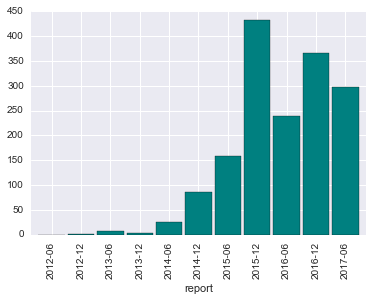

In [20]:
withholdings.groupby("report")\
    ["accounts_withheld"].sum()\
    .plot(kind = "bar", color = "teal", width = 0.9)
pass

Removal requests:

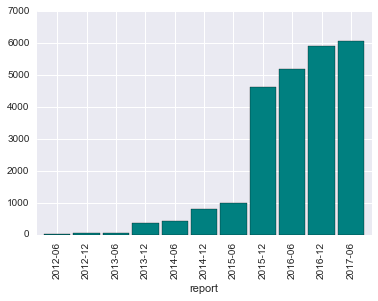

In [21]:
withholdings.groupby("report")\
    ["removal_requests"].sum()\
    .plot(kind = "bar", color = "teal", width = 0.9)
pass

## Step 5: Examine semiannual counts for three key countries

#### Turkey

In [22]:
withholdings[
    withholdings["ISO CODE"] == "TR"
]

,report,ISO CODE,removal_requests,tweets_withheld,accounts_withheld
4,2012-06,TR,1,0,0
16,2012-12,TR,6,0,0
34,2013-06,TR,7,0,0
59,2013-12,TR,2,0,0
87,2014-06,TR,186,183,17
118,2014-12,TR,477,1820,62
152,2015-06,TR,718,1667,125
195,2015-12,TR,2211,3003,414
247,2016-06,TR,2493,1571,222
308,2016-12,TR,3076,489,290


#### Germany

In [23]:
withholdings[
    withholdings["ISO CODE"] == "DE"
]

,report,ISO CODE,removal_requests,tweets_withheld,accounts_withheld
8,2012-12,DE,2,0,1
21,2013-06,DE,4,0,3
41,2013-12,DE,2,0,0
68,2014-06,DE,2,0,0
97,2014-12,DE,43,6,14
128,2015-06,DE,14,6,10
164,2015-12,DE,10,1,1
209,2016-06,DE,63,4,4
267,2016-12,DE,236,121,2
331,2017-06,DE,443,121,0


#### France

In [24]:
withholdings[
    withholdings["ISO CODE"] == "FR"
]

,report,ISO CODE,removal_requests,tweets_withheld,accounts_withheld
0,2012-06,FR,1,0,0
10,2012-12,FR,1,44,0
24,2013-06,FR,3,12,0
44,2013-12,FR,309,133,0
71,2014-06,FR,108,30,0
100,2014-12,FR,35,15,0
131,2015-06,FR,32,2,0
169,2015-12,FR,154,74,2
215,2016-06,FR,466,51,4
274,2016-12,FR,1334,335,14


---

---

---